In [1]:
!pip install textblob
!python -m textblob.download_corpora


[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [4]:
from google.colab import files

# Upload chatbot_data.tsv and embeddings.tsv
uploaded = files.upload()


Saving chatbot_data.tsv to chatbot_data (1).tsv


In [6]:
import pandas as pd

# Load the TSV file into a DataFrame
df = pd.read_csv("chatbot_data.tsv", sep="\t")

# Show the first few rows to understand its structure
df.head()


,user,agent
0,how do i change my flight date?,you can change your flight date by logging int...
1,what is the baggage allowance for internationa...,the baggage allowance for international flight...
2,my flight was canceled. what should i do?,we apologize for the inconvenience. please con...
3,can i upgrade my seat?,"yes, you can upgrade your seat by visiting our..."
4,how do i check in online?,you can check in online 24 hours before your f...


# Run TextBlob Sentiment Analysis on Both user and agent Columns

In [7]:
from textblob import TextBlob

# Convert values to string and analyze both user and agent columns
df['user_polarity'] = df['user'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df['user_subjectivity'] = df['user'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

df['agent_polarity'] = df['agent'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df['agent_subjectivity'] = df['agent'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

# Show a few rows of results
df[['user', 'user_polarity', 'user_subjectivity', 'agent', 'agent_polarity', 'agent_subjectivity']].head(10)


,user,user_polarity,user_subjectivity,agent,agent_polarity,agent_subjectivity
0,how do i change my flight date?,0.000000,0.000000,you can change your flight date by logging int...,0.000000,0.000000
1,what is the baggage allowance for internationa...,0.000000,0.000000,the baggage allowance for international flight...,0.000000,0.000000
2,my flight was canceled. what should i do?,0.000000,0.000000,we apologize for the inconvenience. please con...,0.000000,0.000000
3,can i upgrade my seat?,0.000000,0.000000,"yes, you can upgrade your seat by visiting our...",0.000000,0.000000
4,how do i check in online?,0.000000,0.000000,you can check in online 24 hours before your f...,0.000000,0.000000
5,how do i check my flight status?,0.000000,0.000000,you can check your flight status by visiting t...,0.000000,0.000000
6,what is the carry-on baggage allowance?,0.000000,0.000000,"the carry-on baggage allowance is 1 bag, up to...",0.250000,0.312500
7,i missed my connecting flight. what can i do?,0.000000,0.000000,we apologize for the inconvenience. please go ...,0.000000,0.000000
8,can i add extra baggage to my booking?,0.000000,0.100000,"yes, you can add extra baggage by logging into...",0.000000,0.100000
9,how can i request a special meal for my flight?,0.357143,0.571429,you can request a special meal during booking ...,0.278571,0.535714


Add Sentiment Labels (Positive / Negative / Neutral)

In [8]:
# Labeling user messages
def get_sentiment_label(p):
    if p > 0:
        return "Positive"
    elif p < 0:
        return "Negative"
    else:
        return "Neutral"

df['user_sentiment'] = df['user_polarity'].apply(get_sentiment_label)
df['agent_sentiment'] = df['agent_polarity'].apply(get_sentiment_label)


Bar Chart – Count of Each Sentiment


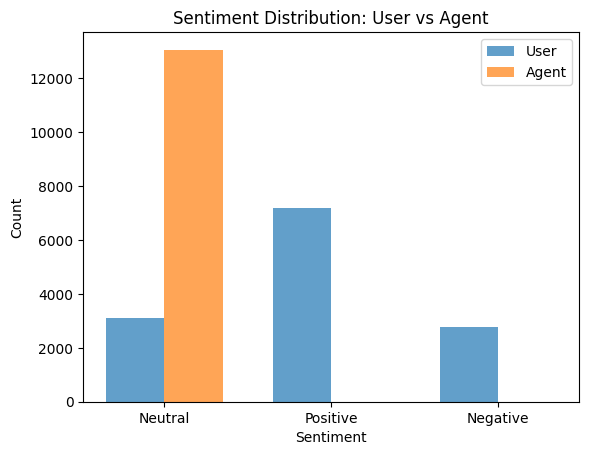

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Count sentiment categories for both user and agent, ensuring all categories are present
# Use pd.concat instead of append to combine the Series
all_sentiments = pd.concat([df['user_sentiment'], df['agent_sentiment']]).unique()
user_counts = df['user_sentiment'].value_counts().reindex(all_sentiments, fill_value=0)
agent_counts = df['agent_sentiment'].value_counts().reindex(all_sentiments, fill_value=0)

# Bar chart
fig, ax = plt.subplots()
bar_width = 0.35
index = range(len(all_sentiments))  # Index based on all possible sentiments

ax.bar(index, user_counts, bar_width, label='User', alpha=0.7)
ax.bar([i + bar_width for i in index], agent_counts, bar_width, label='Agent', alpha=0.7)

ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')
ax.set_title('Sentiment Distribution: User vs Agent')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(all_sentiments)  # Labels based on all possible sentiments
ax.legend()

plt.show()

Line Plot – Polarity Over Time

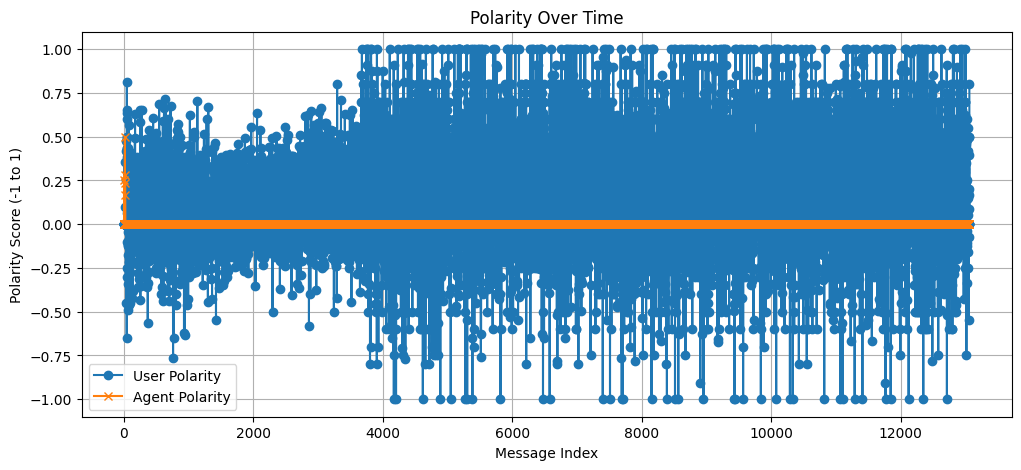

In [10]:
# Line plot showing how emotion changes over message index
plt.figure(figsize=(12, 5))

plt.plot(df['user_polarity'], label='User Polarity', marker='o')
plt.plot(df['agent_polarity'], label='Agent Polarity', marker='x')

plt.title('Polarity Over Time')
plt.xlabel('Message Index')
plt.ylabel('Polarity Score (-1 to 1)')
plt.legend()
plt.grid(True)
plt.show()


# LAB 11: Sentiment Analysis Using scikit-learn (LinearSVC)

STEP 1: Install and Import Libraries

In [11]:
!pip install scikit-learn

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC


Create a Small, Balanced Training Dataset

In [12]:
# Sample training data with sentiment labels
train_texts = [
    "I love this!", "That was amazing.", "This is great.",
    "I hate it.", "This is terrible.", "Awful experience.",
    "It's okay.", "Not bad.", "Could be better.",
    "I'm very happy.", "I'm very disappointed."
]

train_labels = ["pos", "pos", "pos",   # positive
                "neg", "neg", "neg",   # negative
                "neu", "neu", "neu",   # neutral
                "pos", "neg"]          # mix


 Convert Text to Vectors (TF-IDF)

In [13]:
# Convert words into numerical form using TF-IDF
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_texts)


 Train the LinearSVC Model


In [14]:
# Train a Linear Support Vector Classifier
model = LinearSVC()
model.fit(X_train, train_labels)


LinearSVC()

Predict Sentiment for Chatbot Messages



In [15]:
# Predict sentiment on chatbot user messages
user_messages = df['user'].astype(str)
X_test = vectorizer.transform(user_messages)
predictions = model.predict(X_test)

# Add predictions to the DataFrame
df['ML_sentiment'] = predictions
df[['user', 'ML_sentiment']].head(10)


,user,ML_sentiment
0,how do i change my flight date?,neg
1,what is the baggage allowance for internationa...,neg
2,my flight was canceled. what should i do?,pos
3,can i upgrade my seat?,neg
4,how do i check in online?,neg
5,how do i check my flight status?,neg
6,what is the carry-on baggage allowance?,neg
7,i missed my connecting flight. what can i do?,neg
8,can i add extra baggage to my booking?,neg
9,how can i request a special meal for my flight?,neg


In [16]:
# Recalculate TextBlob sentiment labels (just in case)
def get_sentiment_label(p):
    if p > 0:
        return "Positive"
    elif p < 0:
        return "Negative"
    else:
        return "Neutral"

df['TextBlob_sentiment'] = df['user_polarity'].apply(get_sentiment_label)


Compare Counts with a Bar Chart

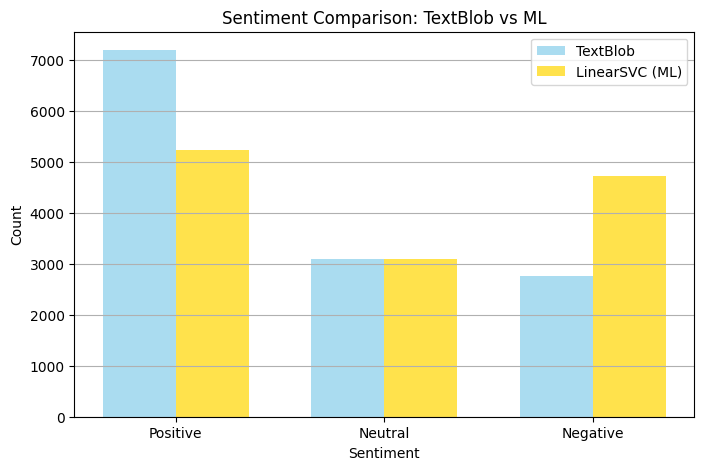

In [17]:
import matplotlib.pyplot as plt

# Step 1: Map ML labels to match TextBlob style
ml_map = {'pos': 'Positive', 'neg': 'Negative', 'neu': 'Neutral'}
df['ML_sentiment_label'] = df['ML_sentiment'].map(ml_map)

# Step 2: Count for both methods using same labels
sentiment_labels = ['Positive', 'Neutral', 'Negative']
blob_counts = df['TextBlob_sentiment'].value_counts()
ml_counts = df['ML_sentiment_label'].value_counts()

blob_values = [blob_counts.get(label, 0) for label in sentiment_labels]
ml_values = [ml_counts.get(label, 0) for label in sentiment_labels]

# Step 3: Plot side-by-side bars
bar_width = 0.35
index = range(len(sentiment_labels))

plt.figure(figsize=(8, 5))
plt.bar(index, blob_values, bar_width, label='TextBlob', alpha=0.7, color='skyblue')
plt.bar([i + bar_width for i in index], ml_values, bar_width, label='LinearSVC (ML)', alpha=0.7, color='gold')

plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Comparison: TextBlob vs ML')
plt.xticks([i + bar_width / 2 for i in index], sentiment_labels)
plt.legend()
plt.grid(axis='y')
plt.show()


In [18]:
# Show the first 10 comparisons
df[['user', 'TextBlob_sentiment', 'ML_sentiment']].head(10)


,user,TextBlob_sentiment,ML_sentiment
0,how do i change my flight date?,Neutral,neg
1,what is the baggage allowance for internationa...,Neutral,neg
2,my flight was canceled. what should i do?,Neutral,pos
3,can i upgrade my seat?,Neutral,neg
4,how do i check in online?,Neutral,neg
5,how do i check my flight status?,Neutral,neg
6,what is the carry-on baggage allowance?,Neutral,neg
7,i missed my connecting flight. what can i do?,Neutral,neg
8,can i add extra baggage to my booking?,Neutral,neg
9,how can i request a special meal for my flight?,Positive,neg
